In [1]:
import requests, json, numpy, datetime
import pywren
import boto3
import numpy as np
from pyproj import Proj
import warnings
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
# Leaving this here if needed: https://medium.com/@jenoyamma/how-to-install-python-packages-for-aws-lambda-layer-74e193c76a91
BUCKET = 'mapping-disaster-risk'

GEOJSONS = ['train-borde_rural.geojson', 'train-borde_soacha.geojson',
            'train-castries.geojson', 'train-dennery.geojson',
            'train-gros_islet.geojson', 'train-mixco_1_and_ebenezer.geojson',
            'train-mixco_3.geojson']

TIFS = ['borde_rural_ortho-cog.tif', 'borde_soacha_ortho-cog.tif',
        'castries_ortho-cog.tif', 'dennery_ortho-cog.tif',
        'gros_islet_ortho-cog.tif', 'mixco_1_and_ebenezer_ortho-cog.tif',
        'mixco_3_ortho-cog.tif']

tif_list = [{'tif':"mixco_3_ortho-cog.tif",
    'crs': 'epsg:32616',
    'geojson': 'train-mixco_3.geojson',
    'output': 'guatemala_mixco_3_zonal.csv'}]



In [3]:
# Note that all geojsonn names are the object names as well, so to access an object call:
# https://mapping-disaster-risk.s3.amazonaws.com/train-borde_rural.geojson

In [99]:
# Step 1: Get all geojsons and create new footprint dictionaries
def get_geojsons(dictionary):
    '''
    Given a full geojson dictionary, extracts relevant information for each
    building, including type, building id, roof material, and coordinates.
    Returns a list of dictionaries, where each dictionary maps a building by
    these features.
   
    Input:
        geojson (str): name of geojson dictionary
    
    Output:
        polygons (lst): a list of dictionaries (one per building)
    '''
    geojson = dictionary['geojson']
    tif = dictionary['tif']
    crs = dictionary['crs']
    output = dictionary['output']

    try:
        s3 = boto3.client('s3', 'us-east-1')
        obj = s3.get_object(Bucket='mapping-disaster-risk', Key=geojson)
        geo_json = json.load(obj['Body'])

    except Exception as e:
        raise e

    return geo_json

In [100]:
def map_tiff(polygon):

    URL = 'https://mapping-disaster-risk.s3.amazonaws.com/mixco_3_ortho-cog.tif'
    
    try:
#         s3 = boto3.client('s3', 'us-east-1')
#         obj = s3.get_object(Bucket='mapping-disaster-risk', Key=geojson)
#         geo_json = json.load(obj['Body'])
        
        tiff = rasterio.open(URL)
        rv = tiff.shape


    except Exception as e:
        return e

    return rv

In [101]:
# DELETE YOU GOT CUTE
# def get_geojsons_JAMES(geojson):
    
#     try:
#         s3 = boto3.client('s3', 'us-east-1')
#         obj = s3.get_object(Bucket='mapping-disaster-risk', Key=geojson)
#         geo_json = json.load(obj['Body'])

#     except Exception as e:
#         return e

#     return {'key':geojson,'file': geo_json}

In [102]:
# PARALLEL GET GEOJSONS
pwex = pywren.default_executor()
futures = pwex.map(get_geojsons, tif_list)

In [103]:
all_geojsons = pywren.get_all_results(futures)

In [105]:
all_geojsons

[{'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'id': '7a243732',
    'properties': {'id': '7a243732',
     'roof_material': 'healthy_metal',
     'verified': True},
    'geometry': {'type': 'Polygon',
     'coordinates': [[[-90.5762815717411, 14.613690151674064],
       [-90.57625574335032, 14.61374490786261],
       [-90.57619788775492, 14.613722178878561],
       [-90.57622268301009, 14.613664323283274],
       [-90.5762815717411, 14.613690151674064]]]}},
   {'type': 'Feature',
    'id': '7a3df348',
    'properties': {'id': '7a3df348',
     'roof_material': 'healthy_metal',
     'verified': True},
    'geometry': {'type': 'Polygon',
     'coordinates': [[[-90.57681983540516, 14.613585804975287],
       [-90.57680227209943, 14.613620931586809],
       [-90.57675144182627, 14.613595516450289],
       [-90.57676900513201, 14.613560389838824],
       [-90.57681983540516, 14.613585804975287]]]}},
   {'type': 'Feature',
    'id': '7a2c1b5a',
    'properties': {'id': 

In [106]:
# YOU GOT CUTE JAMES
# # FROM UML PROJECT
# def make_polygons(geojson):
    
#     file_name = geojson['key']
#     file = geojson['file']
#     polygons = []

#     for feature in file['features']:
#         polygon = {}
#         polygon['type'] = feature['geometry']['type']
#         polygon['bid'] = feature['id']
#         polygon['roof_material'] = feature['properties']['roof_material']
#         polygon['coordinates'] = feature['geometry']['coordinates']
#         polygons.append(polygon)

#     return {'key': file_name, 'file': polygons}

In [114]:
# FROM UML PROJECT
def make_polygons(geojson):
    
#     file_name = geojson['key']
#     file = geojson['file']
    polygons = []

    for feature in geojson['features']:
        polygon = {}
        polygon['type'] = feature['geometry']['type']
        polygon['bid'] = feature['id']
        polygon['roof_material'] = feature['properties']['roof_material']
        polygon['coordinates'] = feature['geometry']['coordinates']
        polygons.append(polygon)

    return polygons

In [115]:
GEOS = ['train-borde_rural.geojson', 'train-borde_soacha.geojson',
            'train-castries.geojson', 'train-dennery.geojson']

In [109]:
two_geojsons = all_geojsons[:2]

In [178]:
two_geojsons[0]

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '7a3f2a10',
   'properties': {'id': '7a3f2a10',
    'roof_material': 'concrete_cement',
    'verified': True},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-74.15872901622859, 4.55513208404803],
      [-74.15869565550265, 4.555234421743102],
      [-74.15864296010655, 4.555217122695224],
      [-74.15867632083824, 4.555114785003784],
      [-74.15872901622859, 4.55513208404803]]]}},
  {'type': 'Feature',
   'id': '7a1f731e',
   'properties': {'id': '7a1f731e',
    'roof_material': 'irregular_metal',
    'verified': True},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-74.15879484827516, 4.555159047202581],
      [-74.15876112811927, 4.555251495820111],
      [-74.15870434247019, 4.555230637593402],
      [-74.15873806263139, 4.555138188979648],
      [-74.15879484827516, 4.555159047202581]]]}},
  {'type': 'Feature',
   'id': '7a424ad8',
   'properties': {'id': '7a424ad8',
    'roof_material'

In [169]:
type(two_geojsons)

list

In [150]:
# GET POLYGONS PARALLELIZED
pwex = pywren.default_executor()
futures = pwex.map(make_polygons, all_geojsons)
all_polygons = pywren.get_all_results(futures)

In [151]:
all_polygons[0]

[{'type': 'Polygon',
  'bid': '7a243732',
  'roof_material': 'healthy_metal',
  'coordinates': [[[-90.5762815717411, 14.613690151674064],
    [-90.57625574335032, 14.61374490786261],
    [-90.57619788775492, 14.613722178878561],
    [-90.57622268301009, 14.613664323283274],
    [-90.5762815717411, 14.613690151674064]]]},
 {'type': 'Polygon',
  'bid': '7a3df348',
  'roof_material': 'healthy_metal',
  'coordinates': [[[-90.57681983540516, 14.613585804975287],
    [-90.57680227209943, 14.613620931586809],
    [-90.57675144182627, 14.613595516450289],
    [-90.57676900513201, 14.613560389838824],
    [-90.57681983540516, 14.613585804975287]]]},
 {'type': 'Polygon',
  'bid': '7a2c1b5a',
  'roof_material': 'healthy_metal',
  'coordinates': [[[-90.57721862575897, 14.61366948896142],
    [-90.57718659855442, 14.61374490786261],
    [-90.57714765410435, 14.613728369808484],
    [-90.5771796813089, 14.613652950907294],
    [-90.57721862575897, 14.61366948896142]]]},
 {'type': 'Polygon',
  'bid':

In [152]:
# FROM THE UML project
def transform_coordinates_UML(polygon):
    
    transform = Proj(init='epsg:32616')
    coordinates_lists = polygon['coordinates']
    transformed_coordinates_lists = []
    
    for coordinates_list in coordinates_lists:
        inner_coord_list = []
        for coordinate in coordinates_list:
            transformed_coordinate = list(transform(coordinate[0],
                                                    coordinate[1]))
            inner_coord_list.append(transformed_coordinate)
        transformed_coordinates_lists.append(inner_coord_list)
    
    polygon['coordinates'] = transformed_coordinates_lists
    
    return polygon

In [153]:
# TRYING TO PARALLEIZE TRANSFORM // DISCUSS WHAT WENT WRONG AND ISSUES WITH PYPROJ
# pwex = pywren.default_executor()
# futures = pwex.map(transform_coordinates_UML, polygons)

In [154]:
# GOT CUTE -- DELETE
# transformed_polygons = []

# for geojson in all_polygons:
#     rv = {}
#     file_name = geojson['key']
#     rv['key'] = file_name
#     rv['file'] = []
#     for polygon in geojson['file']:
#         transformed = transform_coordinates_UML(polygon)
#         rv['file'].append(transformed)
#         transformed_polygons.append(rv)

In [156]:
# SERIALIZE TRANSFORM IF NECESSARY
#     Given building footprints, executes an affine transformation on each
#     coordinate pair to output a new coordinate pair based on a provided
#     coordinate reference system (crs) from the corresponding geotiff file.
#     Serial since Proj is not natively installed on Lambda.

transformed_polygons = []

for polygon in all_polygons[0]: # why is index on 0 necessary again?
    transformed = transform_coordinates_UML(polygon)
    transformed_polygons.append(transformed)

In [159]:
len(all_polygons[0])

159

In [158]:
len(transformed_polygons)

159

In [61]:
# GETS THE IMAGE || UNCOMMENT TO MASK AWS AND GET IMAGE
def get_rooftop_array_after_mask(polygon):
    '''
    Given a dictionary containing transformed coordinates for one roof,
    returns an array of arrays, each one providing a numeric value for each
    pixel in the image for a specific band (in this case, 4 matrices for 4
    bands).
    Eg. Values from 0-255 correspond with the color scale.
    Input:
        tiff_path (str): path to the tif file
        polygon (dict): a dictionary of features including coordinates for a
                        single building
    Output:
        out_image (numpy array): a numpy of values per pixel for each
                                 band (one per image layer)
    '''
    
    tiff_path = 'https://mapping-disaster-risk.s3.amazonaws.com/mixco_3_ortho-cog.tif'
    with rasterio.open(tiff_path) as tiff:
        try:
            out_image, out_transform = mask(tiff, [polygon], crop=True)
        except Exception as e:
             pass
        else:
            return out_image

In [80]:
tst = transformed_polygons[0]['file'][0]

In [160]:
image_list = []

for polygon in transformed_polygons:
    rv = {}
    array = get_rooftop_array_after_mask(polygon)
    rv['roof_material'] = polygon['roof_material']
    rv['img_array'] = array
    image_list.append(rv)
        

In [172]:
image_list[0]['img_array']

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

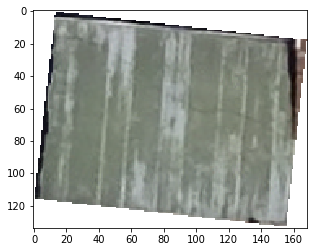

In [163]:
show(image_list[130]['img_array'])

In [178]:
def get_zonals(roof_dict):
    
    material = roof_dict['roof_material']
    roof = roof_dict['img_array']

    zonal_list = []
    for i in range(roof.shape[0] - 1):
        zonal_list.append(np.median(roof[i]))

    return {'material': material, 'stats': zonal_list}

In [180]:
# GET ZONALS BABY ROUND 2
pwex = pywren.default_executor()
future = pwex.map(get_zonals, image_list)
all_zonals = pywren.get_all_results(future)